<a href="https://colab.research.google.com/github/wlz99/c3aiHackathon/blob/main/deepdive_mobility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C3.ai COVID-19 Data Lake Deep Dive - Mobility and Case Counts

Last updated: June 23, 2020.

This Python Jupyter notebook shows some possible analyses using mobility and case count data in the C3.ai COVID-19 Data Lake. See the [API documentation](https://c3.ai/covid-19-api-documentation/) for more details. Note that the [R Deep Dive notebook](https://c3.ai/covid-19-api-documentation/#section/Quickstart-Guide) contains more detailed analysis, while this Python Jupyter notebook shows only preliminary data access and visualization.

Please contribute your questions, answers and insights on [Stack Overflow](https://www.stackoverflow.com). Tag `c3ai-datalake` so that others can view and help build on your contributions. For support, please send email to: [covid@c3.ai](mailto:covid@c3.ai).

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/DMC20_Data/c3ai

/content/drive/My Drive/DMC20_Data/c3ai


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime

Ensure that you have a recent version of pandas (>= 1.0.0).

In [ ]:
print("pandas version", pd.__version__)
assert pd.__version__[0] >= "1", "To use this notebook, upgrade to the newest version of pandas. See https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html for details."


pandas version 1.1.2


<a id="helpers"></a>
## Helper methods for accessing the API

The helper methods in `c3aidatalake.py` convert a JSON response from the C3.ai APIs to a Pandas DataFrame. You may wish to view the code in `c3aidatalake.py` before using the quickstart examples.

In [ ]:
import c3aidatalake

## County comparison

We will compare data from the following datasets across Bay Area counties:
- Confirmed case counts from Johns Hopkins University: COVID-19 Data Repository
- Walking, driving, and transit mobility indices from Apple: COVID-19 Mobility Trends
- Parks, residential, retail, grocery, transit stations, and workplaces mobility from Google: COVID-19 Community Mobility Reports
- Device exposure indices from PlaceIQ Exposure Indices

In [ ]:
today = pd.Timestamp.now() - datetime.timedelta(days = 7)
today = today.strftime("%Y-%m-%d")

locations = [
    "SanFrancisco_California_UnitedStates",
    "SanMateo_California_UnitedStates",
    "SantaClara_California_UnitedStates",
    "Alameda_California_UnitedStates"
]

metrics = [
    "JHU_ConfirmedCases",
    "JHU_ConfirmedDeaths",
    "Apple_TransitMobility",
    "Apple_WalkingMobility", 
    "Apple_DrivingMobility",
    "Google_ParksMobility",
    "Google_ResidentialMobility",
    "Google_GroceryMobility",
    "Google_TransitStationsMobility",
    "Google_RetailMobility",
    "Google_WorkplacesMobility",
    "PlaceIQ_DeviceExposure_Adjusted"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : locations,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

complete_timeseries

,dates,SanFrancisco_California_UnitedStates.JHU_ConfirmedCases.data,SanFrancisco_California_UnitedStates.JHU_ConfirmedCases.missing,SanFrancisco_California_UnitedStates.Apple_WalkingMobility.data,SanFrancisco_California_UnitedStates.Apple_WalkingMobility.missing,SanFrancisco_California_UnitedStates.Apple_TransitMobility.data,SanFrancisco_California_UnitedStates.Apple_TransitMobility.missing,SanFrancisco_California_UnitedStates.JHU_ConfirmedDeaths.data,SanFrancisco_California_UnitedStates.JHU_ConfirmedDeaths.missing,SantaClara_California_UnitedStates.JHU_ConfirmedCases.data,SantaClara_California_UnitedStates.JHU_ConfirmedCases.missing,SantaClara_California_UnitedStates.Apple_WalkingMobility.data,SantaClara_California_UnitedStates.Apple_WalkingMobility.missing,SantaClara_California_UnitedStates.Apple_TransitMobility.data,SantaClara_California_UnitedStates.Apple_TransitMobility.missing,SantaClara_California_UnitedStates.JHU_ConfirmedDeaths.data,SantaClara_California_UnitedStates.JHU_ConfirmedDeaths.missing,Alameda_California_UnitedStates.JHU_ConfirmedCases.data,Alameda_California_UnitedStates.JHU_ConfirmedCases.missing,Alameda_California_UnitedStates.Apple_WalkingMobility.data,Alameda_California_UnitedStates.Apple_WalkingMobility.missing,Alameda_California_UnitedStates.Apple_TransitMobility.data,Alameda_California_UnitedStates.Apple_TransitMobility.missing,Alameda_California_UnitedStates.JHU_ConfirmedDeaths.data,Alameda_California_UnitedStates.JHU_ConfirmedDeaths.missing,SanMateo_California_UnitedStates.JHU_ConfirmedCases.data,SanMateo_California_UnitedStates.JHU_ConfirmedCases.missing,SanMateo_California_UnitedStates.Apple_WalkingMobility.data,SanMateo_California_UnitedStates.Apple_WalkingMobility.missing,SanMateo_California_UnitedStates.Apple_TransitMobility.data,SanMateo_California_UnitedStates.Apple_TransitMobility.missing,SanMateo_California_UnitedStates.JHU_ConfirmedDeaths.data,SanMateo_California_UnitedStates.JHU_ConfirmedDeaths.missing,SanFrancisco_California_UnitedStates.Apple_DrivingMobility.data,SanFrancisco_California_UnitedStates.Apple_DrivingMobility.missing,SanFrancisco_California_UnitedStates.Google_ResidentialMobility.data,SanFrancisco_California_UnitedStates.Google_ResidentialMobility.missing,SanFrancisco_California_UnitedStates.Google_GroceryMobility.data,SanFrancisco_California_UnitedStates.Google_GroceryMobility.missing,SanFrancisco_California_UnitedStates.Google_ParksMobility.data,...,SanMateo_California_UnitedStates.Apple_DrivingMobility.data,SanMateo_California_UnitedStates.Apple_DrivingMobility.missing,SanMateo_California_UnitedStates.Google_ResidentialMobility.data,SanMateo_California_UnitedStates.Google_ResidentialMobility.missing,SanMateo_California_UnitedStates.Google_GroceryMobility.data,SanMateo_California_UnitedStates.Google_GroceryMobility.missing,SanMateo_California_UnitedStates.Google_ParksMobility.data,SanMateo_California_UnitedStates.Google_ParksMobility.missing,SanFrancisco_California_UnitedStates.Google_WorkplacesMobility.data,SanFrancisco_California_UnitedStates.Google_WorkplacesMobility.missing,SanFrancisco_California_UnitedStates.Google_RetailMobility.data,SanFrancisco_California_UnitedStates.Google_RetailMobility.missing,SanFrancisco_California_UnitedStates.Google_TransitStationsMobility.data,SanFrancisco_California_UnitedStates.Google_TransitStationsMobility.missing,SanFrancisco_California_UnitedStates.PlaceIQ_DeviceExposure_Adjusted.data,SanFrancisco_California_UnitedStates.PlaceIQ_DeviceExposure_Adjusted.missing,SantaClara_California_UnitedStates.Google_WorkplacesMobility.data,SantaClara_California_UnitedStates.Google_WorkplacesMobility.missing,SantaClara_California_UnitedStates.Google_RetailMobility.data,SantaClara_California_UnitedStates.Google_RetailMobility.missing,SantaClara_California_UnitedStates.Google_TransitStationsMobility.data,SantaClara_California_UnitedStates.Google_TransitStationsMobility.missing,SantaClara_California_UnitedStates.PlaceIQ_DeviceExposure_Adjusted.data,Sa

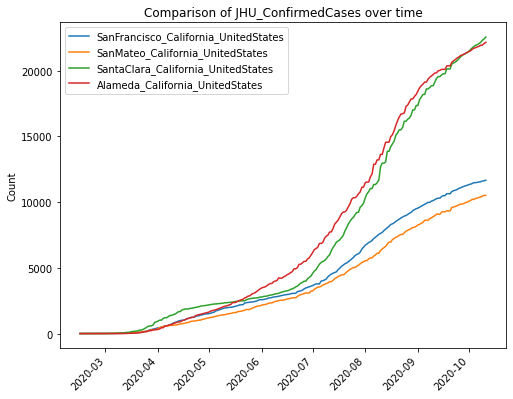

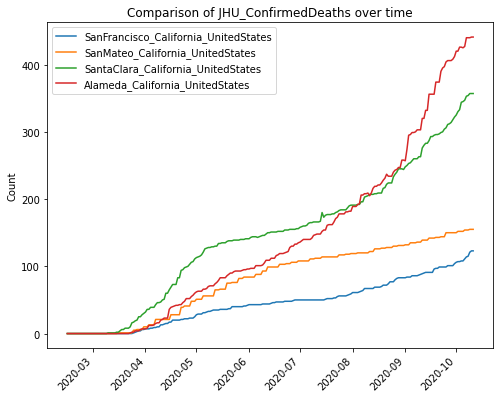

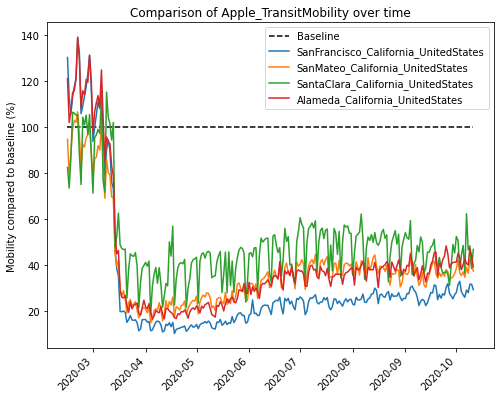

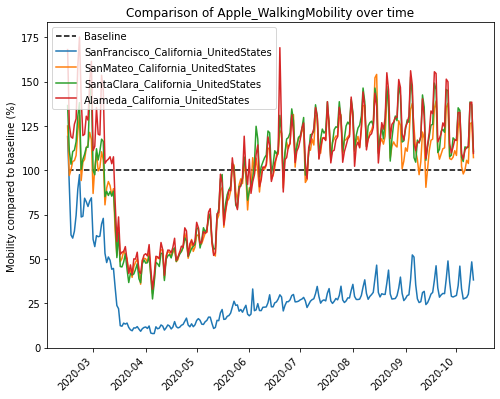

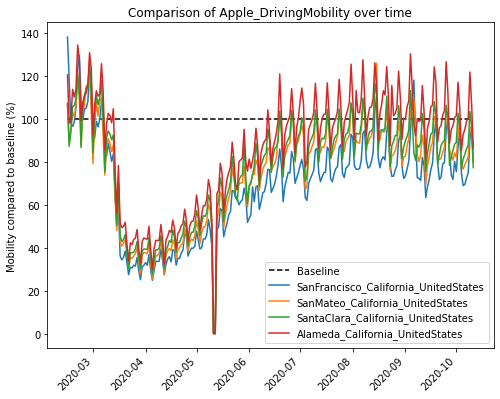

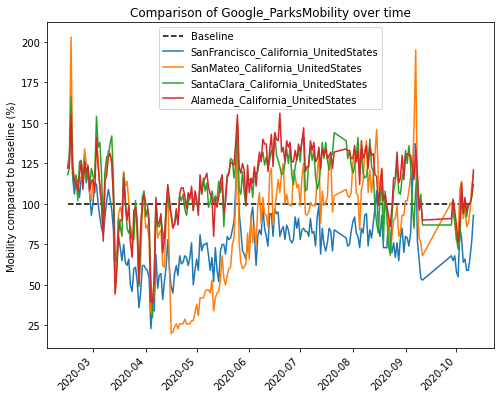

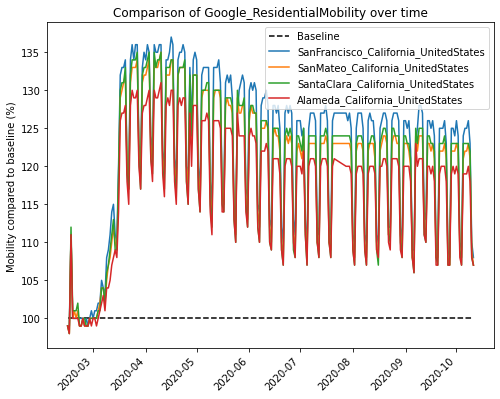

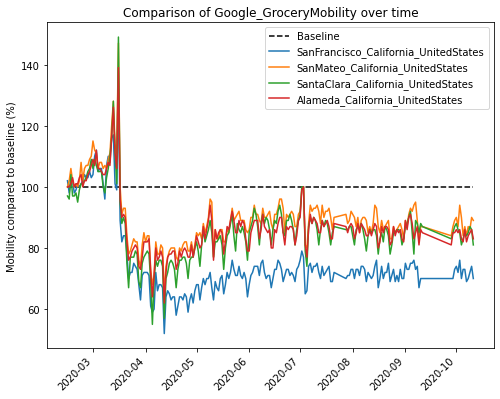

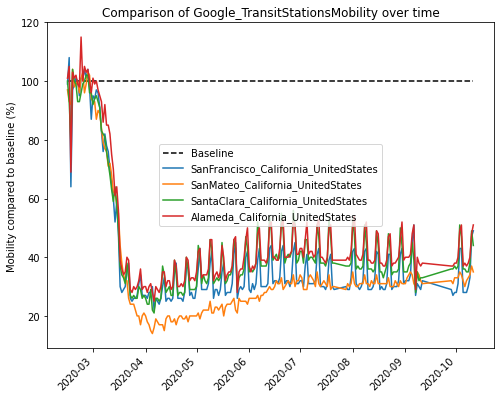

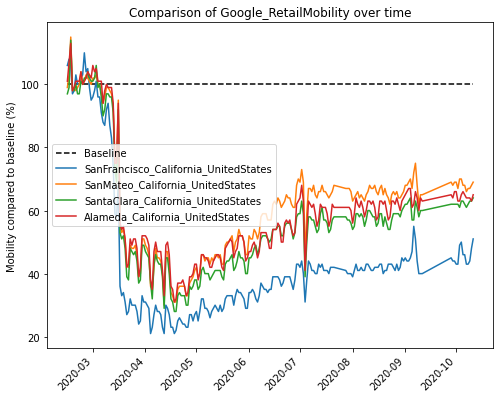

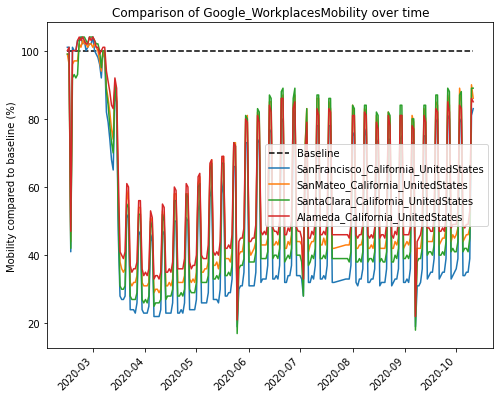

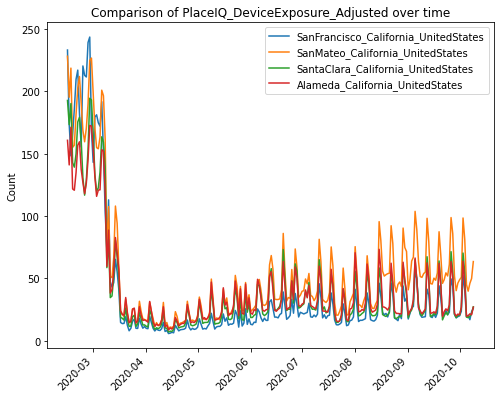

In [ ]:
for metric in metrics:
    plt.figure(figsize = (8, 6))

    if "Mobility" in metric:
        plt.plot(
            complete_timeseries["dates"],
            [100 for d in complete_timeseries["dates"]],
            label = "Baseline",
            linestyle = "dashed",
            color = "black"
        )

    for location in locations:
        data_col = location + "." + metric + ".data"
        missing_col = location + "." + metric + ".missing"

        missing = list(complete_timeseries[missing_col])
        data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
        dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

        plt.plot(
            dates,
            data,
            label = location
        )

    plt.legend()
    plt.xticks(rotation = 45, ha = "right")
    if "Mobility" in metric:
        plt.ylabel("Mobility compared to baseline (%)")
    else:
        plt.ylabel("Count")
    plt.title("Comparison of " + metric + " over time")
    plt.show()

In general, Alemeda tends to have slightly higher mobility and device exposure. Google retail mobility is substantially lower in San Francisco than other counties.

Let's compare case counts and mobility directly. You can edit the locations and metrics below to view other comparisons.

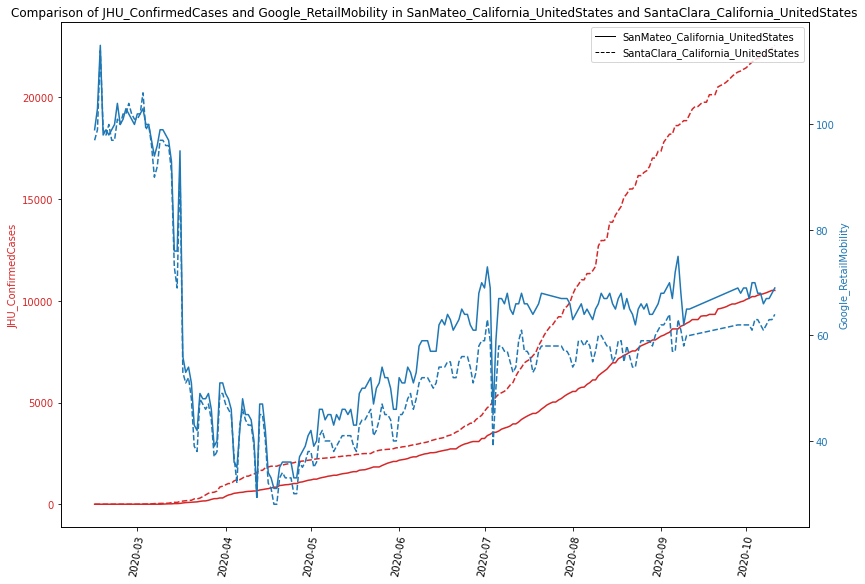

In [ ]:
from matplotlib.lines import Line2D

metric1 = "JHU_ConfirmedCases"
metric2 = "Google_RetailMobility"

location1 = "SanMateo_California_UnitedStates"
location2 = "SantaClara_California_UnitedStates"

all_locations = [location1, location2]
linestyles = ["solid", "dashed"]

fig, ax1 = plt.subplots(figsize = (12, 8))
color = 'tab:red'
ax1.set_ylabel(metric1, color = color)
ax1.tick_params(axis='y', labelcolor = color)

for i, location in enumerate(all_locations):
    data_col = location + "." + metric1 + ".data"
    missing_col = location + "." + metric1 + ".missing"

    missing = list(complete_timeseries[missing_col])
    data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
    dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

    ax1.plot(
        dates,
        data,
        ls = linestyles[i],
        color = color,
        label = location
    )


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(metric2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

for i, location in enumerate(all_locations):
    data_col = location + "." + metric2 + ".data"
    missing_col = location + "." + metric2 + ".missing"

    missing = list(complete_timeseries[missing_col])
    data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
    dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

    ax2.plot(
        dates,
        data,
        ls = linestyles[i],
        color = color,
        label = location
    )

plt.legend([
    Line2D([0], [0], color = "black", linestyle = linestyles[0], lw=1),
    Line2D([0], [0], color = "black", linestyle = linestyles[1], lw=1)
], all_locations)

ax1.tick_params(axis='x', labelrotation = 80)

fig.tight_layout()
plt.title("Comparison of " + metric1 + " and " + metric2 + " in " + location1 + " and " + location2)
plt.show()

These visualizations show the options to manipulate and use mobility and case count data from the C3.ai COVID-19 Data Lake. For full analysis of these data, see the [R Deep Dive notebook](https://c3.ai/covid-19-api-documentation/#section/Quickstart-Guide). In bringing together data sets from disparate sources, the C3.ai COVID-19 Data Lake permits in-depth and real-time data exploration. 

If any publications or research results are derived in full or in part from the C3.ai COVID-19 Data Lake, please make sure to credit the C3.ai COVID-19 Data Lake by referencing the case study at https://c3.ai/customers/covid-19-data-lake/.